In [3]:
import json 
import os
import logging 
import concurrent 
import asyncio 
import re 
import requests 

from collections import deque 
from itertools import chain 

from pprint import PrettyPrinter

from box import Box
from subgrounds import Subgrounds
from palettable.tableau import Tableau_20
from palettable.mycarta import Cube1_4, Cube1_8
from dotenv import load_dotenv

from web3 import Web3
from web3.exceptions import ContractLogicError

# apis / networking 
from etherscan import Etherscan
from pycoingecko import CoinGeckoAPI

import pandas as pd 
import numpy as np 
import altair as alt 

from flywheel_util.constants import colors_24, colors_28, url_subgraphs
from flywheel_util.utils.util import (
    ddf, 
    remove_prefix, 
    query_attrs, 
    camel_to_snake, 
    df_cols_camel_to_snake, 
    df_cols_change_prefix, 
    graphql_execute, 
    first_row, 
)

# logging.basicConfig(level=logging.INFO)

assert load_dotenv("../.env") 

pp = PrettyPrinter().pprint

alt.data_transformers.disable_max_rows()
alt.renderers.enable('jupyterlab')

RendererRegistry.enable('jupyterlab')

In [4]:
# Setup API clients 
infura_url = f'https://mainnet.infura.io/v3/{os.environ["INFURA_API_KEY"]}'
w3 = Web3(Web3.HTTPProvider(infura_url))
cg = CoinGeckoAPI()
etherscan = Etherscan(os.environ['ETHERSCAN_API_KEY'])

In [5]:
sg = Subgrounds()
sg_fraxlend = sg.load_subgraph(url_subgraphs.frax.fraxlend)

In [6]:
url = "https://api.thegraph.com/subgraphs/name/frax-finance-data/fraxlend-subgraph---mainnet"
q = """
query fraxlendpairs {
    pairs {
        maxLTV
        liquidationFee
        maturity
        pauseStatus
        lenderWhitelistActive
        borrowerWhitelistActive
        asset {
            symbol
            decimals
            address
            name
        }
        collateral {
            symbol
            decimals
            address
            name
        }
        positions(orderBy: borrowedAssetShare, orderDirection: desc) {
            user {
              id
            }
            borrowedAssetShare
            depositedCollateralAmount
            lentAssetShare
            timestamp
        }
        dailyHistory(first: 1, orderBy: timestamp, orderDirection: desc) {
            id
            exchangeRate
            totalAssetAmount
            totalAssetShare
            totalCollateral
            totalBorrowAmount
            totalBorrowShare
            totalBorrowValue
            totalAssetValue
            totalCollateralValue
            interestPerSecond
            utilization
            totalFeesAmount
            totalFeesShare
            lastAccrued
            timestamp
        }
    }
}
"""

pairs_last = await graphql_execute(url, q, query_name="pairs") 
pairs_last = list(map(Box, pairs_last))

q_pairs = """
query MyQuery {
  pairPerDays(first: 1000) {
    timestamp
    totalAssetAmount
    totalAssetShare
    totalAssetValue
    totalBorrowAmount
    totalBorrowValue
    totalCollateral
    totalCollateralValue
    totalFeesAmount
    totalFeesShare
    utilization
    lastAccrued
    id
    interestPerSecond
    feeToProtocolRate
    exchangeRate
    block
    totalBorrowShare
    pair {
      name
      maxLTV
      asset {
        decimals
        name
      }
      collateral {
        decimals
        name
      }
    }
  }
}
"""

pairs = await graphql_execute(url, q_pairs, query_name='pairPerDays') 
pairs = list(map(Box, pairs))

In [7]:
len(pairs)

1000

In [8]:
print(pairs[0])

{'timestamp': '1669233755', 'totalAssetAmount': '244858658822131937429', 'totalAssetShare': '244853354310336464200', 'totalAssetValue': '24485865882213193742900000000', 'totalBorrowAmount': '184856173057801416503', 'totalBorrowValue': '18485617305780141650300000000', 'totalCollateral': '298834308882641875', 'totalCollateralValue': '354926599827350654907067329477560408750', 'totalFeesAmount': '0', 'totalFeesShare': '0', 'utilization': '75495', 'lastAccrued': '16034947', 'id': '0x21e354da5d929a4da55428f6bfd71ed9ffd5001f-19319', 'interestPerSecond': '1456709290', 'feeToProtocolRate': '0', 'exchangeRate': '841960870298269', 'block': '16034947', 'totalBorrowShare': '184852059846876894847', 'pair': {'name': 'Fraxlend Interest Bearing FRAX (Staked Frax Ether) - 9', 'maxLTV': '75000', 'asset': {'decimals': '18', 'name': 'Frax'}, 'collateral': {'decimals': '18', 'name': 'Staked Frax Ether'}}}


In [9]:
pairs_records = []
for p in pairs: 
    asset_decimals = int(p.pair.asset.decimals)
    reserves = float(p.totalAssetAmount) / (10**asset_decimals) 
    liquidity = reserves - (float(p.totalBorrowAmount) / (10**asset_decimals))
    secs_per_year = 24 * 365 * 3600
    utilization = float(p.utilization) / (10**5) 
    interest_per_second = float(p.interestPerSecond) / (10 ** int(p.pair.asset.decimals))
    borrow_apr = (1 + interest_per_second) ** secs_per_year - 1
    supply_apr = borrow_apr * utilization
    pairs_records.append({
        "date": pd.to_datetime(pd.to_datetime(p.timestamp, unit='s').date()), 
        "asset": p.pair.asset.name, 
        "collateral": p.pair.collateral.name, 
        "reserves": reserves, # The total amount of FRAX that can be borrowed within this pair 
        "liquidity": liquidity, # The remaining amount of FRAX that can be borrowed within this pair 
        "total_locked_collateral": float(p.totalCollateral) / (10**asset_decimals), 
        "utilization_rate": utilization, 
        "max_ltv": float(p.pair.maxLTV) / 1e5, 
        "supply_apy": supply_apr, 
        "borrow_apy": borrow_apr, 
    })
    
df_pairs = pd.DataFrame(pairs_records).sort_values('date').reset_index(drop=True) 
df_pairs['rank'] = df_pairs.groupby(['date', 'collateral']).cumcount()
df_pairs = df_pairs.set_index(['date', 'collateral'])
df_pairs['max_rank'] = df_pairs.groupby(['date', 'collateral'])[['rank']].max()
df_pairs = df_pairs.reset_index()
df_pairs = df_pairs.loc[df_pairs['rank'] == df_pairs['max_rank']].drop(columns=['rank', 'max_rank'])
df_pairs.sort_values(['date', 'collateral']).tail()

,date,collateral,asset,reserves,liquidity,total_locked_collateral,utilization_rate,max_ltv,supply_apy,borrow_apy
998,2023-01-14,Curve DAO Token,Frax,3.074719e+07,1.175722e+07,1.049785e+08,0.61761,0.75,0.050767,0.082198
996,2023-01-14,Frax Price Index,Frax,1.502590e+07,1.854915e+06,1.661829e+07,0.87655,0.95,0.020218,0.023065
999,2023-01-14,Governance OHM,Frax,3.389847e+06,4.744244e+05,2.593195e+03,0.86004,0.75,0.082890,0.096380
997,2023-01-14,Staked Frax Ether,Frax,4.392374e+06,4.844523e+05,6.676799e+03,0.88970,0.75,0.040247,0.045236
994,2023-01-14,Wrapped Ether,Frax,3.308970e+06,2.015939e+06,1.623912e+03,0.39076,0.75,0.000976,0.002498


/opt/miniconda3/envs/flywheel/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


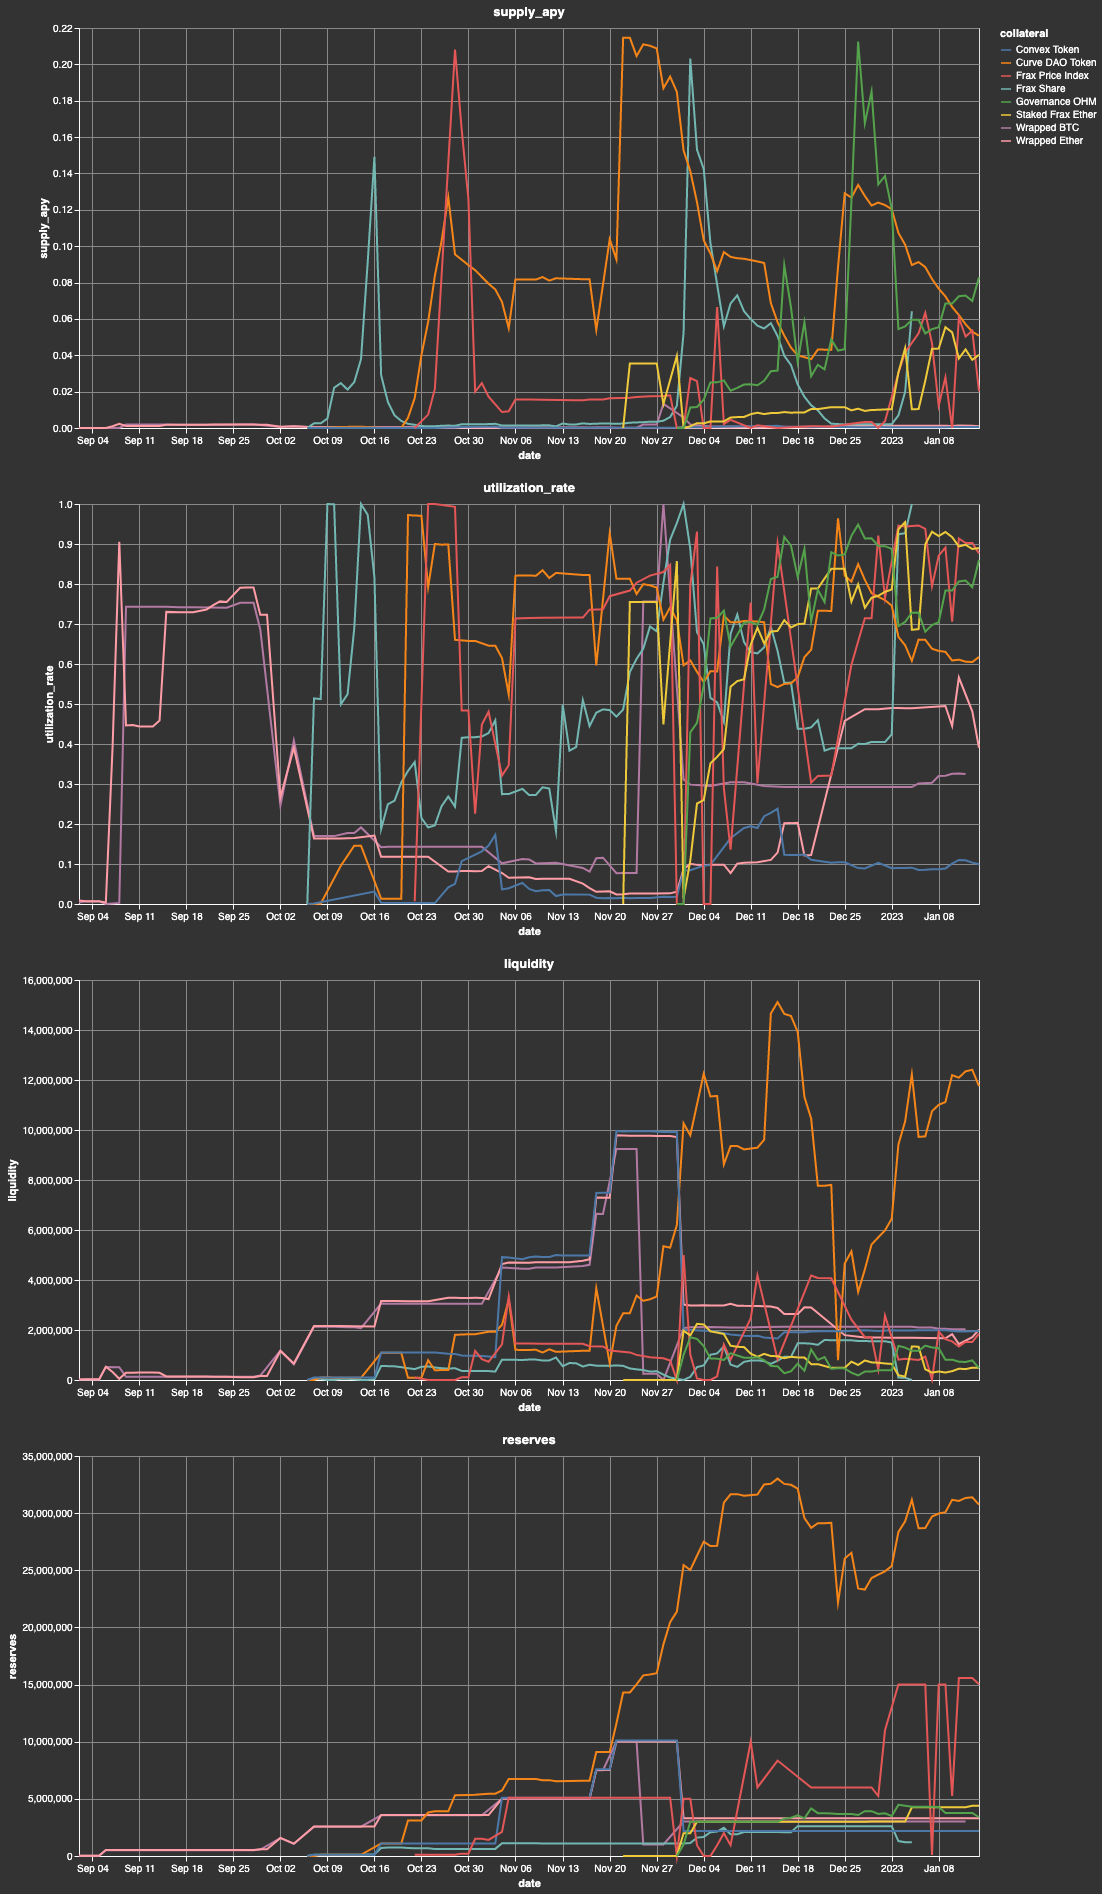

In [10]:
selection = alt.selection_multi(fields=['collateral'], bind='legend')
nearest = alt.selection_single(
    fields=['timestamp'], nearest=True, on='mouseover', empty='none', clear='mouseout'
)

charts = []
for v in ['supply_apy', 'utilization_rate', 'liquidity', 'reserves']: 
    base = alt.Chart(df_pairs).encode(x="date:T") 
    charts.append(
        (
            base
            .mark_line()
            .encode(
                y=f"{v}:Q", 
                color="collateral:N", 
                tooltip=["date:T", f"{v}:Q", "collateral:N"],
                opacity=alt.condition(selection, alt.value(1), alt.value(0.2))
            )
            .properties(width=900, height=400, title=v)
            .add_selection(selection)
        ) + (
            base 
            .transform_pivot("collateral", groupby=['date'], value=v)
            .mark_rule() 
            .encode(
                tooltip=[alt.Tooltip(c, type='quantitative', format="%") for c in df_pairs.collateral.unique()],
                opacity=alt.condition(nearest, alt.value(0.3), alt.value(0)),
            )
            .add_selection(nearest)
        )
    )
    
    
alt.vconcat(*charts)

In [18]:
positions = []
for pair in pairs_last: 
    h = Box(pair['dailyHistory'][0])
    # pair APR computation 
    max_ltv = float(pair['maxLTV']) / 10**5
    asset_borrow = pair['asset']['symbol']
    asset_collat = pair['collateral']['symbol']
    asset_decimals = float(pair['asset']['decimals'])
    collat_decimals = float(pair['collateral']['decimals'])
    
    pair_total_borrow_amt = h['totalBorrowAmount']
    pair_total_borrow_share = h['totalBorrowShare']
    # price of collateral asset denominated in FRAX
    price_collat_in_frax = 1 / (float(h['exchangeRate']) / 10**collat_decimals)
    # print(asset_borrow, asset_collat, pair_exchange_rate, )
    
    for pos in pair['positions']: 
        borrow_amount = (
            float(pos['borrowedAssetShare']) / float(pair_total_borrow_share) * float(pair_total_borrow_amt) / 10**(asset_decimals)
            if float(pair_total_borrow_share) != 0 else 
            0 
        )
        collateral_amount = float(pos['depositedCollateralAmount']) / 10**(collat_decimals)
        # FRAX is borrow asset (lent to user -> numerator), other is collateral (value supplied by user -> denominator) 
        ltv = (
            # both numerator and denominator have frax units 
            borrow_amount / (collateral_amount * price_collat_in_frax) 
            if collateral_amount > 0 
            else 0
        )
        # price at which value of collateral == max_ltv * borrow amount 
        # User borrows 18.92M Frax 
        # User supplies 104.9M Crv 
        # Current price of Crv (in FRAX) is .5464) 
        # Liquidation price: .24 Frax / CRV 
        # User is liquidated when ltv == max_ltv, meaning value of collateral is at min allowed threshold
        # Here is our equation for when this is true 
        # borrow_amount / (collateral_amount * liq_price) = max_ltv  
        # Now solving for single unknown liq_price 
        # borrow_amount / max_ltv / collateral_amount = liq_price
        liq_price = (
            borrow_amount / max_ltv / collateral_amount
            if collateral_amount  > 0 
            else 0
        )
        positions.append({
            "user": pos['user']['id'], 
            "borrow_amount": borrow_amount, 
            "collateral_amount": collateral_amount, 
            "collateral_amount_frax": collateral_amount * price_collat_in_frax, 
            "collateral_amount_frax_liq": collateral_amount * liq_price, 
            "current_ltv": ltv, 
            "max_ltv": max_ltv, 
            "liq_price": liq_price, 
            "collateral_asset": asset_collat, 
            "cur_price": price_collat_in_frax, 
        })
        
df_positions = pd.DataFrame(positions)

In [13]:
ddf(df_positions.sort_values('borrow_amount', ascending=False).head(5))

,user,borrow_amount,collateral_amount,collateral_amount_frax,collateral_amount_frax_liq,current_ltv,max_ltv,liq_price,collateral_asset,cur_price
129,0x7a16ff8270133f063aab6c9977183d9e72835428,1.896727e+07,1.049000e+08,8.495468e+07,2.528970e+07,0.223263,0.75,0.241084,CRV,0.809863
351,0xb1bd5762faf7d6f86f965a3ff324bd81bb746d00,7.027084e+06,9.102399e+06,9.694536e+06,7.396930e+06,0.724850,0.95,0.812635,FPI,1.065053
425,0x88e863d4572d2dae27db81e98837a9dbeb0e7a12,3.440526e+06,3.738992e+06,3.982225e+06,3.621606e+06,0.863971,0.95,0.968605,FPI,1.065053
352,0x4c42522b28ae01b2153f51d85a8ee7631d243ef5,2.364404e+06,2.504869e+06,2.667818e+06,2.488846e+06,0.886269,0.95,0.993603,FPI,1.065053
353,0xec9e4a0ed746b24b0c7ccf22f270be54f725fb4b,1.995535e+06,2.086330e+06,2.222051e+06,2.100563e+06,0.898060,0.95,1.006822,FPI,1.065053


In [17]:
# df_positions.loc[df_positions.collateral_asset == 'CVX'].sort_values("liq_price", ascending=False)

In [15]:
def vega_grid(charts, ncols=3):
    assert ncols > 0
    i = 0
    row = []
    rows = []
    while i < len(charts):
        row.append(charts[i])
        i += 1 
        if len(row) == ncols: 
            rows.append(row) 
            row = []
    if row: 
        rows.append(row) 
    chart_rows = [alt.hconcat(*r) for r in rows]
    chart_grid = alt.vconcat(*chart_rows)
    return chart_grid

/opt/miniconda3/envs/flywheel/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


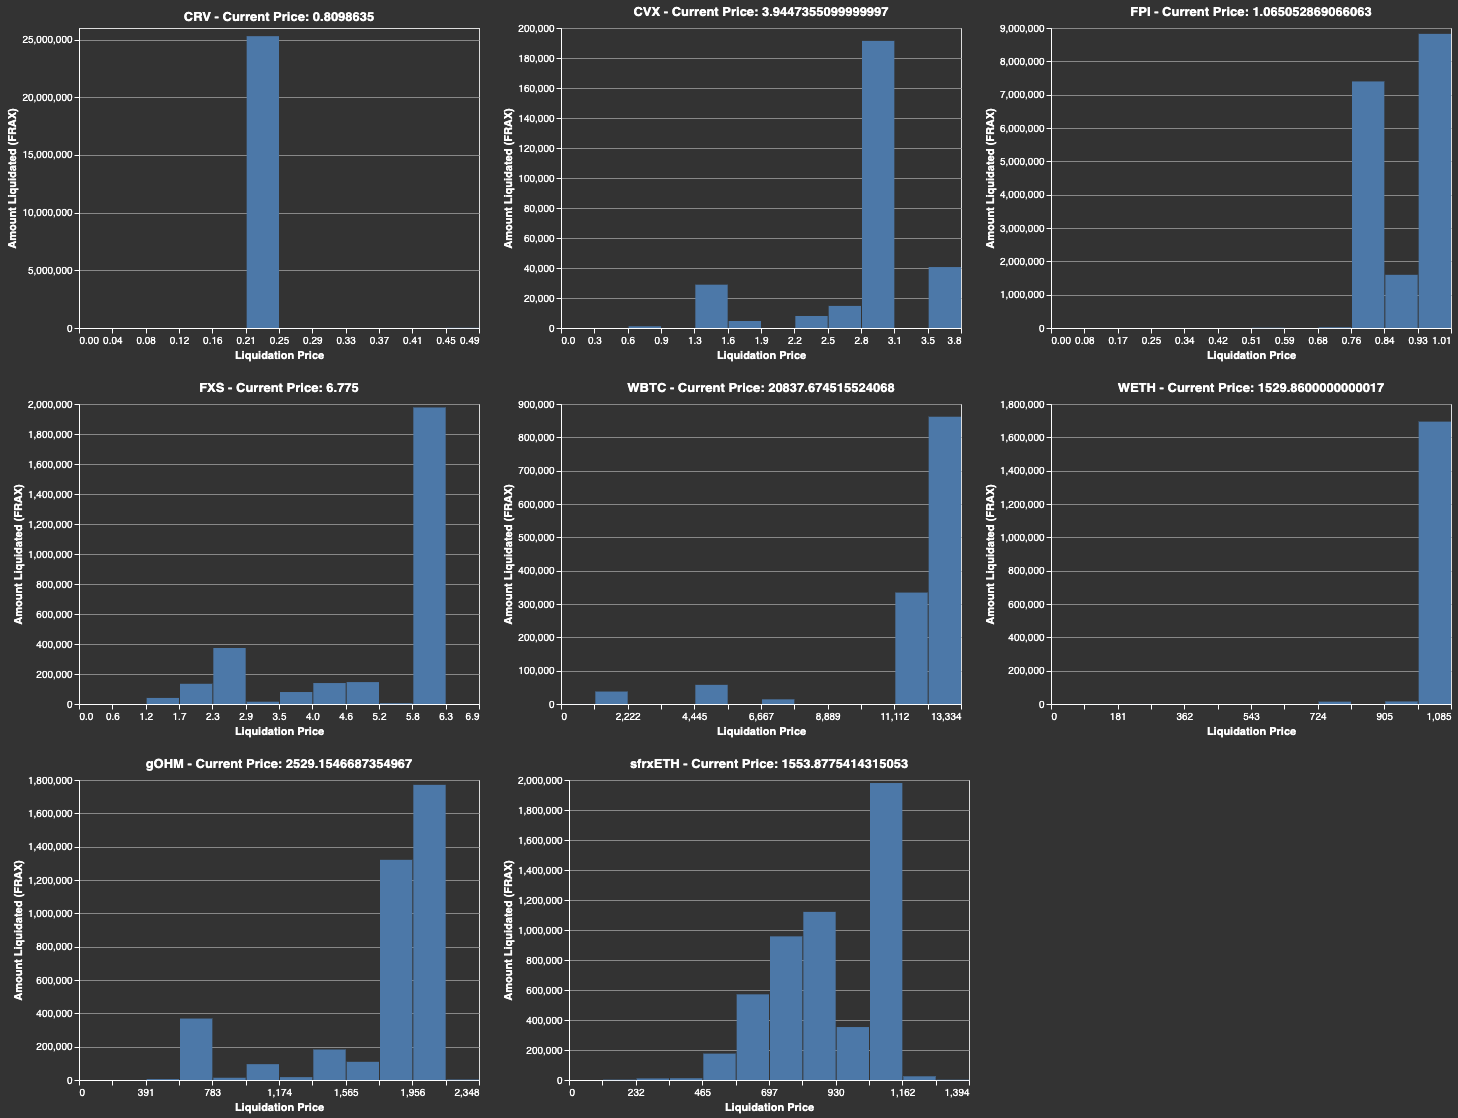

In [16]:
charts = []
nbins = 12
for g, gdf in df_positions.groupby('collateral_asset'):
    cur_price = gdf.cur_price.max()
    lo, hi = gdf.liq_price.min(), gdf.liq_price.max()
    charts.append(
        alt.Chart(gdf, title=f"{g} - Current Price: {cur_price}")
        .mark_bar() 
        .encode(
            x=alt.X("liq_price:Q", bin=alt.Bin(extent=(lo, hi), step=(hi-lo) / nbins), axis=alt.Axis(title="Liquidation Price")),
            y=alt.Y("sum(collateral_amount_frax_liq):Q", axis=alt.Axis(title="Amount Liquidated (FRAX)")), 
        )
    )
vega_grid(charts)

In [ ]:
# df_positions.loc[df_positions.collateral_asset == 'CVX'].collateral_amount.sum()